In [45]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid")

from scipy.sparse import csr_matrix, load_npz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

In [48]:
train = load_npz('1.4-sm-feature-engineered-location.npz')

In [49]:
train.shape

(39048, 1389)

In [50]:
labels = pd.read_csv('1.4-sm-feature-engineered-location-labels.csv', )

In [51]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39048 entries, 0 to 39047
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   stars   39048 non-null  int64
dtypes: int64(1)
memory usage: 305.2 KB


In [52]:
labels.stars.values

array([8, 9, 4, ..., 8, 9, 9], dtype=int64)

In [53]:
labels = labels >= 7

In [54]:
labels = labels.astype(np.int)

C:\Users\Checkout\AppData\Local\Temp\ipykernel_22668\1136154699.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  labels = labels.astype(np.int)


In [55]:
labels.stars.value_counts()

1    26498
0    12550
Name: stars, dtype: int64

In [56]:
X = train
y = labels.stars.values

In [58]:
X_train, X_cv, y_train, y_cv = train_test_split( 
              X, y, test_size = 0.4, random_state = 42, stratify = y) 

In [59]:
X_cv, X_test, y_cv, y_test = train_test_split(X_cv, y_cv, test_size=0.1, random_state=42, stratify=y_cv)

In [60]:
print(X_train.shape)
print(X_test.shape)
print(X_cv.shape)

(23428, 1389)
(14058, 1389)
(1562, 1389)


In [63]:
def gridTrainModel(estimator, params, train, y, cv=5):
    model = GridSearchCV(estimator, params, scoring='accuracy',cv=cv, n_jobs=-1)
    model.fit(train, y)
    return model

In [64]:
def randomTrainModel(estimator, params, train, y, cv=5, n_iter=10):
    model = RandomizedSearchCV(estimator, params, scoring='accuracy',cv=cv, n_iter=n_iter, n_jobs=-1)
    model.fit(train, y)
    return model

## Lasso Regression

In [66]:
logreg = LogisticRegression(penalty='l1', dual=False, solver='liblinear', random_state=0)

In [68]:
params_dist = {  
    "max_iter": st.randint(100,300),
    "C": st.uniform(1.1, 3.0)
}
params_grid = {  
    "max_iter": [200, 210, 220],
    "C": [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
}

In [69]:
%%time 
model = trainModelRandom(logreg, params_dist, X_train, y_train)

CPU times: total: 1 s
Wall time: 8.69 s


In [70]:
model.best_score_

0.692248934244515

In [71]:
model.best_estimator_

LogisticRegression(C=2.0250828677260797, max_iter=218, penalty='l1',
                   random_state=0, solver='liblinear')

In [72]:
cv_predict = model.best_estimator_.predict(X_cv)

In [74]:
accuracy_score(y_cv, cv_predict)

0.6912789870536349

## Decision Tree

In [76]:
dt = DecisionTreeClassifier(random_state=0)

In [77]:
params_grid = {
    "max_depth" : np.arange(1, 25, 1)
}

In [78]:
%%time
model = trainModelGrid(dt, params_grid, X_train, y_train)

CPU times: total: 594 ms
Wall time: 19.6 s


In [79]:
model.best_score_

0.7188836248303833

In [80]:
model.best_estimator_

DecisionTreeClassifier(max_depth=6, random_state=0)

In [81]:
cv_predict = model.best_estimator_.predict(X_cv)

In [82]:
accuracy_score(y_cv, cv_predict)

0.7207995447432067

In [83]:
model.cv_results_['mean_test_score']

array([0.67858972, 0.7030049 , 0.7070173 , 0.70829808, 0.71738921,
       0.71888362, 0.71585275, 0.71572479, 0.7094076 , 0.71077388,
       0.70834062, 0.70432857, 0.70338963, 0.70104179, 0.69737083,
       0.69489522, 0.69370022, 0.68994398, 0.68652926, 0.68537648,
       0.6844802 , 0.68311442, 0.68294373, 0.68123641])

In [84]:
np.argmax(model.cv_results_['mean_test_score'])

5

<AxesSubplot:>

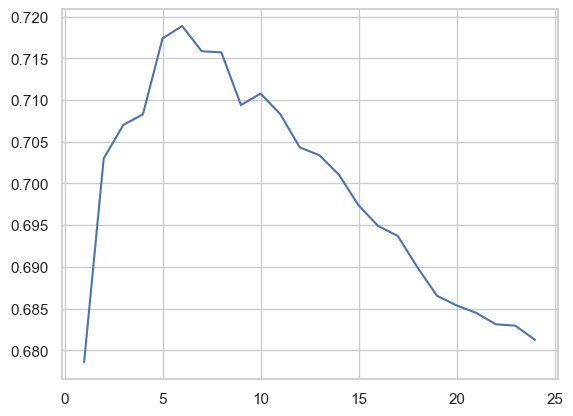

In [85]:
sns.lineplot(x=np.arange(1,25,1), y=model.cv_results_['mean_test_score'])

In [86]:
model.best_estimator_.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

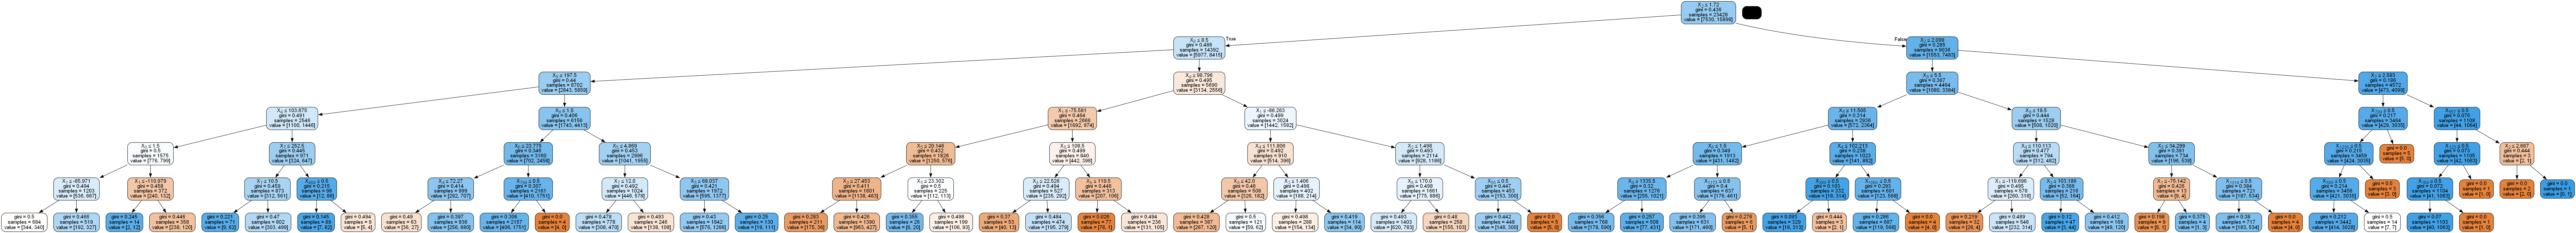

In [88]:
dot_data = StringIO()

export_graphviz(model.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
graph.write_png('dtree-graph.png') #../models/
Image(graph.create_png())

## Gradient Boosted Trees

In [90]:
xgb = XGBClassifier(random_state=0)

In [91]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params_dist = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40),
    "learning_rate": st.uniform(0.05, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}

In [92]:
%%time
model = trainModelRandom(xgb, params_dist, X_train, y_train, cv=20, n_iter=50)

CPU times: total: 14.8 s
Wall time: 7min 12s


In [93]:
model.best_score_

0.7385188267080148

In [94]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.8085074244738621, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.3084365223070815, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.40105247910941183, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=9, max_leaves=0, min_child_weight=15.016973538659496,
              missing=nan, monotone_constraints='()', n_estimators=25, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [95]:
cv_predict = model.best_estimator_.predict(X_cv)

In [96]:
accuracy_score(y_cv, cv_predict)

0.7422819746763408

## Random Forest Classifier

In [98]:
rf = RandomForestClassifier(random_state=0)

In [99]:
params_dist = {  
    "n_estimators": st.randint(3, 40),
    "max_depth": st.randint(3, 40)
}

In [100]:
%%time
model = trainModelRandom(rf, params_dist, X_train, y_train)

CPU times: total: 4.56 s
Wall time: 14.1 s


In [101]:
model.best_score_

0.712992774407839

In [102]:
model.best_estimator_

RandomForestClassifier(max_depth=28, n_estimators=33, random_state=0)

In [103]:
cv_predict = model.best_estimator_.predict(X_cv)

In [104]:
accuracy_score(y_cv, cv_predict)

0.716887181675914

## Support Vector Classifier

In [105]:
from sklearn.svm import LinearSVC

In [106]:
svc = LinearSVC(dual=False, random_state=0)

In [107]:
params = {  
    "C": [1.2, 1.3, 1.4, 1.5, 1.6, 1.7]
}

In [108]:
params_dist = {  
    "C": st.uniform(1.0, 2.0)
}

In [109]:
%%time
model = trainModelRandom(svc, params_dist, X_train, y_train)

CPU times: total: 375 ms
Wall time: 4.79 s


In [110]:
model.best_score_

0.6917364970522335

In [111]:
model.best_estimator_

LinearSVC(C=1.7471498742737892, dual=False, random_state=0)

In [112]:
cv_predict = model.best_estimator_.predict(X_cv)

In [113]:
accuracy_score(y_cv, cvPredicted)

0.6845212690283112